<a href="https://colab.research.google.com/github/armandossrecife/piloto/blob/main/notebooks/temp/compara_Tsoukalas2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Dependencies

* [GitPython](https://gitpython.readthedocs.io/en/stable) - to clone git repositories
* [CLOC](https://github.com/AlDanial/cloc) - to calculate CLOC and other source code metrics





In [1]:
!pip3 install gitpython

In [2]:
!sudo apt install cloc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cloc is already the newest version (1.90-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


# 2. Dataset of Tsoukalas2023

On the relation between architectural smells and source code changes - ?

replication kit - ?

In [3]:
!wget ?

http://?: Invalid host name.


## 2.1 Replication Kit data and scripts

In [4]:
!wget ?

http://?: Invalid host name.


In [5]:
!unzip replication-package.zip

unzip:  cannot find or open replication-package.zip, replication-package.zip.zip or replication-package.zip.ZIP.


# 3. Details of the analyzed projects

Selection criteria:

* Project lifetime (in years)
* number of commits
* Number of released releases
* Number of files
* Number of .java files
* Number of participants (contributors)
* Relevance in the open-source community
** Amount of stars

In [6]:
repository_project_list = ['kafka', 'cassandra', 'activemq', 'guava']
repository_project_list

['kafka', 'cassandra', 'activemq', 'guava']

### Support classes to CLOC

In [7]:
import os
import subprocess
import json
import pandas as pd
import requests
import threading
import datetime
from git import Repo
import csv

class DirectoryAnalyzer:
    def __init__(self, target_directory, cloc_output_file="cloc_output.json"):
        self.target_directory = target_directory
        self.cloc_output_file = cloc_output_file

    def cloc(self):
        os.chdir(self.target_directory)
        try:
            # Run CLOC to analyze the repository and save the output as JSON
            subprocess.run(["cloc", "--json","."], stdout=open(self.cloc_output_file, "w"))
        except Exception as ex:
            print(f'Error: {str(ex)}')


        # Load JSON output from CLOC
        with open(self.cloc_output_file, "r") as json_file:
            cloc_data = json.load(json_file)

        # Extract desired metrics for Java files
        java_metrics = cloc_data.get("Java", {})
        self.total_unique_files = java_metrics.get("nFiles", 0)
        self.total_blank_loc = java_metrics.get("blank", 0)
        self.total_comment_loc = java_metrics.get("comment", 0)
        self.total_loc = java_metrics.get("code", 0)

        sum_metrics = cloc_data.get("SUM", {})
        self.total_nFiles = sum_metrics.get("nFiles",0)
        self.total_LOC_files = sum_metrics.get("code",0)

        return self.total_nFiles, self.total_unique_files, self.total_blank_loc, self.total_comment_loc, self.total_loc, self.total_LOC_files

class RepositoryAnalyzer:
    def __init__(self, target_directory):
        self.target_directory = target_directory

    def get_first_commit_date(self):
        command = ["git", "log", "--reverse", "--format=%ad", "--date=short"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.first_commit_date = result.stdout.splitlines()[0]
        return self.first_commit_date

    def get_last_commit_date(self):
        command = ["git", "log", "-1", "--format=%ad", "--date=short"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.last_commit_date = result.stdout.strip()
        return self.last_commit_date

    def get_total_commit_count(self):
        command = ["git", "rev-list", "--count", "HEAD"]
        result = subprocess.run(command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        self.total_commit_count = int(result.stdout.strip())
        return self.total_commit_count

    def get_total_release_count(self):
        git_tag_command = ["git", "tag"]
        wc_command = ["wc", "-l"]

        git_tag_result = subprocess.run(git_tag_command, cwd=self.target_directory, stdout=subprocess.PIPE, text=True)
        wc_result = subprocess.run(wc_command, input=git_tag_result.stdout, stdout=subprocess.PIPE, text=True)

        self.total_release_count = int(wc_result.stdout.strip())
        return self.total_release_count

def get_repository_name(url):
  repository_name = os.path.splitext(os.path.basename(url))[0]
  return repository_name

def clone_repository(url):
  target_directory = get_repository_name(url)
  subprocess.run(["git", "clone", url, target_directory])

def gera_my_dict(url, total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_loc, total_LOC_files):
    name = get_repository_name(url)
    repository_path = '/content/'+name
    git_repo_analyzer = RepositoryAnalyzer(target_directory=repository_path)
    first_commit_date = git_repo_analyzer.get_first_commit_date()
    last_commit_date = git_repo_analyzer.get_last_commit_date()
    total_commit_count = git_repo_analyzer.get_total_commit_count()
    total_release_count = git_repo_analyzer.get_total_release_count()

    my_dict = {
        'name': [name],
        'files': [total_nFiles],
        'java': [total_unique_files],
        'blank_loc_java': [total_blank_loc],
        'comment_loc_java': [total_comment_loc],
        'loc_java': [total_loc],
        'loc_files': [total_LOC_files],
        'first_commit_date':[first_commit_date],
        'last_commit_date':[last_commit_date],
        'total_commit_count':[total_commit_count],
        'total_release_count':[total_release_count]
    }
    return my_dict

def gera_csv(url, my_dict):
  name = get_repository_name(url)
  my_df = pd.DataFrame.from_dict(my_dict)
  name = name + '.csv'
  name = '/content/'+name
  my_df.to_csv(name, index=False)
  return my_df

class RepoCloner:
    def __init__(self, qtd_repositorios, lista_urls):
        self.qtd_repositorios = qtd_repositorios
        self.lista_urls = lista_urls
        self.lista_threads = []
        self.lista_tempo_inicio = []
        self.lista_tempo_conclusao = []

    def my_clone(self, git_url, repo_dir):
        try:
            Repo.clone_from(git_url, repo_dir)
            tempo = datetime.datetime.now()
            print(f'Clonagem do repo {git_url} concluída com sucesso! -> instante: {tempo}')
            elemento = (repo_dir, tempo)
            self.lista_tempo_conclusao.append(elemento)
        except Exception as ex:
            print(f"Erro ao clonar o repo: {git_url} - {str(ex)}")

    def clona_repositorios(self):
        try:
          for i in range(self.qtd_repositorios):
              nome = get_repository_name(url=self.lista_urls[i])
              tdi = threading.Thread(target=self.my_clone, args=(self.lista_urls[i], nome))
              tdi.name = 'Thread-'+str(i+1)
              inicio_thread = datetime.datetime.now()
              print(f"Thread {i+1} iniciada em {inicio_thread} - clonando {nome}:{self.lista_urls[i]}...")
              self.lista_threads.append(tdi)
              elemento = (nome, inicio_thread)
              self.lista_tempo_inicio.append(elemento)
              tdi.start()

          for each in self.lista_threads:
              each.join()
        except Exception as ex:
          print(f'Erro no clona_repositorio: {str(ex)}')

    def mostra_tempo_clonagens(self):
        for t1 in self.lista_tempo_inicio:
            for t2 in self.lista_tempo_conclusao:
                if t1[0] == t2[0]:
                    print(f"Tempo de clonagem do {t1[0]} é: {t2[1]-t1[1]} s")

class CSVFile:
    def __init__(self, file_path):
        self.file_path = file_path

    def read(self):
        with open(self.file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                yield row

class CSVCombiner:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.accumulated_content = []

    def combine(self):
        for filename in os.listdir(self.folder_path):
            if filename.endswith('.csv'):
                file_path = os.path.join(self.folder_path, filename)
                csv_file = CSVFile(file_path)
                for row in csv_file.read():
                  if 'name' not in row and 'lucene-solr' not in row and 'jackson' not in row:
                      self.accumulated_content.append(row)

    def write(self, output_file_path):
        with open(output_file_path, 'w', newline='') as output_file:
            csv_writer = csv.writer(output_file)
            csv_writer.writerows(self.accumulated_content)

class CSVModifier:
    def __init__(self, csv_file):
        self.csv_file = csv_file

    def insert_new_line(self, new_line):
        existing_content = []
        with open(self.csv_file.file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                existing_content.append(row)

        existing_content.insert(0, new_line)

        with open(self.csv_file.file_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerows(existing_content)

### List the repositories for analysis

In [8]:
lista_repositorios = ['https://github.com/apache/kafka.git', 'https://github.com/apache/cassandra.git', 'https://github.com/apache/activemq.git', 'https://github.com/google/guava.git']
print(lista_repositorios)

['https://github.com/apache/kafka.git', 'https://github.com/apache/cassandra.git', 'https://github.com/apache/activemq.git', 'https://github.com/google/guava.git']


### Clone repositories locally


In [9]:
qtd_repositorios = len(lista_repositorios)
print(f'Clonando os {qtd_repositorios} repositórios. Aguarde...')
cloner = RepoCloner(qtd_repositorios=len(lista_repositorios), lista_urls=lista_repositorios)
cloner.clona_repositorios()
cloner.mostra_tempo_clonagens()
print(f'Clonagem de todos os {qtd_repositorios} concluída com sucesso!')

Clonando os 4 repositórios. Aguarde...
Thread 1 iniciada em 2023-08-27 22:23:31.170323 - clonando kafka:https://github.com/apache/kafka.git...
Thread 2 iniciada em 2023-08-27 22:23:31.185533 - clonando cassandra:https://github.com/apache/cassandra.git...
Thread 3 iniciada em 2023-08-27 22:23:31.186622 - clonando activemq:https://github.com/apache/activemq.git...
Thread 4 iniciada em 2023-08-27 22:23:31.212502 - clonando guava:https://github.com/google/guava.git...
Clonagem do repo https://github.com/apache/activemq.git concluída com sucesso! -> instante: 2023-08-27 22:24:08.273858
Clonagem do repo https://github.com/apache/kafka.git concluída com sucesso! -> instante: 2023-08-27 22:24:45.693926
Clonagem do repo https://github.com/apache/cassandra.git concluída com sucesso! -> instante: 2023-08-27 22:25:42.765216
Clonagem do repo https://github.com/google/guava.git concluída com sucesso! -> instante: 2023-08-27 22:26:12.363832
Tempo de clonagem do kafka é: 0:01:14.523603 s
Tempo de clon

### Analyzes CLOC and other metrics for each cloned repository

In [10]:
for each in lista_repositorios:
  try:
    URL_REPOSITORY = each
    target_directory = get_repository_name(url=URL_REPOSITORY)
    target_directory = '/content/'+target_directory
    json_file = target_directory + '.json'

    print(f'Analise CLOC diretório: {target_directory}')
    directory_analyzer = DirectoryAnalyzer(target_directory=target_directory, cloc_output_file=json_file)
    total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_java_loc, total_files_loc = directory_analyzer.cloc()

    my_dict=gera_my_dict(URL_REPOSITORY,total_nFiles, total_unique_files, total_blank_loc, total_comment_loc, total_java_loc, total_files_loc)

    print(f'Gera o .csv do {URL_REPOSITORY}')
    gera_csv(URL_REPOSITORY,my_dict)
  except Exception as ex:
    print(f'Erro ao fazer a análise CLOC do repositório {each}')

Analise CLOC diretório: /content/kafka
Gera o .csv do https://github.com/apache/kafka.git
Analise CLOC diretório: /content/cassandra
Gera o .csv do https://github.com/apache/cassandra.git
Analise CLOC diretório: /content/activemq
Gera o .csv do https://github.com/apache/activemq.git
Analise CLOC diretório: /content/guava
Gera o .csv do https://github.com/google/guava.git


In [11]:
!rm -rf /content/temp  && mkdir /content/temp
!cp /content/*.csv /content/temp

In [12]:
!ls -liath /content/temp

total 24K
2629176 drwxr-xr-x 2 root root 4.0K Aug 27 22:28 .
2629178 -rw-r--r-- 1 root root  222 Aug 27 22:28 cassandra.csv
2646015 -rw-r--r-- 1 root root  215 Aug 27 22:28 guava.csv
2646016 -rw-r--r-- 1 root root  217 Aug 27 22:28 kafka.csv
2629177 -rw-r--r-- 1 root root  219 Aug 27 22:28 activemq.csv
2752518 drwxr-xr-x 1 root root 4.0K Aug 27 22:28 ..


### Merge all .csv

In [13]:
folder_path = '/content/temp'
output_file_path = '/content/temp/combined.csv'
csv_combiner = CSVCombiner(folder_path)
csv_combiner.combine()
csv_combiner.write(output_file_path)

csv_file_path = '/content/temp/combined.csv'
new_line = ['name','files','java','blank_loc_java','comment_loc_java','loc_java','loc_files','commit_inicial','commit_final','qtd_commits','qtd_releases']
csv_file = CSVFile(csv_file_path)
csv_modifier = CSVModifier(csv_file)
csv_modifier.insert_new_line(new_line)

### Generates the Dataframe of the CLOC analyzes of the repositories

In [14]:
df_cloc_repositories = pd.read_csv('/content/temp/combined.csv')

df_cloc_repositories['commit_inicial'] = pd.to_datetime(df_cloc_repositories['commit_inicial'])
df_cloc_repositories['commit_final'] = pd.to_datetime(df_cloc_repositories['commit_final'])

# Calculate the difference in years
df_cloc_repositories['life_span'] = (df_cloc_repositories['commit_final'] - df_cloc_repositories['commit_inicial']).dt.days / 365

df_cloc_repositories[['name','files','loc_files','java','loc_java','qtd_commits','qtd_releases','life_span']]

,name,files,loc_files,java,loc_java,qtd_commits,qtd_releases,life_span
0,activemq,4922,465609,4355,415820,11448,85,17.646575
1,guava,1968,361115,1909,356775,6163,101,14.191781
2,kafka,5384,849912,4226,624056,11585,222,12.076712
3,cassandra,4997,1055355,4458,680588,29070,297,14.487671


In [29]:
df_temp1 = df_cloc_repositories[['name','files','loc_files','java','loc_java','qtd_commits','qtd_releases','life_span']]
df_temp1 = df_temp1.sort_values(by='name')
df_temp1

,name,files,loc_files,java,loc_java,qtd_commits,qtd_releases,life_span
0,activemq,4922,465609,4355,415820,11448,85,17.646575
3,cassandra,4997,1055355,4458,680588,29070,297,14.487671
1,guava,1968,361115,1909,356775,6163,101,14.191781
2,kafka,5384,849912,4226,624056,11585,222,12.076712


In [26]:
df_temp = pd.read_csv('https://raw.githubusercontent.com/armandossrecife/teste/main/my_repositories_tese.csv')
df_temp = df_temp.sort_values(by='nome')
df_temp

,url,nome,source_java,stars,forks,colaborators
0,https://github.com/apache/activemq.git,activemq,activemq-http/src/main/java,2200,1400,127
1,https://github.com/apache/cassandra.git,cassandra,src/java,8100,3400,424
2,https://github.com/google/guava.git,guava,guava/src,48100,10700,293
3,https://github.com/apache/kafka.git,kafka,core/src,25700,13000,1042


<Axes: >

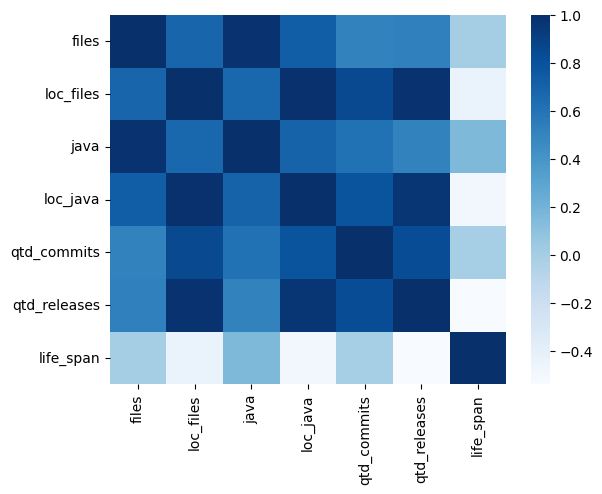

In [30]:
import seaborn as sns

# calculate the correlation matrix on the numeric columns
corr = df_temp1.select_dtypes('number').corr()

sns.heatmap(corr, cmap='Blues')

# 4. Critical files - ATDCodeAnalyzer

Obs: Para os repositórios do ActiveMQ e Guava ainda não foram selecionados os Architectural Smells e Design Smells

## Cassandra

In [ ]:
lista_arquivos_criticos_cassandra = [("StorageService.java", 3537, 144), ("ColumnFamilyStore.java", 1966, 89), ("DatabaseDescriptor.java", 2092, 87), ("CompactionManager.java", 1279, 74), ("StorageProxy.java", 1667, 53), ("SSTableReader.java", 767, 53), ("Config.java", 553, 52), ("CassandraDaemon.java", 1001, 51), ("SelectStatement.java", 1174, 44), ("SinglePartitionReadCommand.java", 994, 38),("NodeProbe.java", 513, 37), ("MessagingService.java", 574, 36)]
lista_arquivos_criticos_cassandra

[('StorageService.java', 3537, 144),
 ('ColumnFamilyStore.java', 1966, 89),
 ('DatabaseDescriptor.java', 2092, 87),
 ('CompactionManager.java', 1279, 74),
 ('StorageProxy.java', 1667, 53),
 ('SSTableReader.java', 767, 53),
 ('Config.java', 553, 52),
 ('CassandraDaemon.java', 1001, 51),
 ('SelectStatement.java', 1174, 44),
 ('SinglePartitionReadCommand.java', 994, 38),
 ('NodeProbe.java', 513, 37),
 ('MessagingService.java', 574, 36)]

![Critial Files Cassandra](https://raw.githubusercontent.com/armandossrecife/piloto/main/graficos/scatter_plot_cassandra.png "Critical Files Cassandra - Parcial").

![Boxplot AMLOC Cassandra](https://raw.githubusercontent.com/armandossrecife/piloto/main/graficos/boxplot_amloc_cassandra.png "Boxplot AMLOC Cassandra")

![Boxplot FOC Cassandra](https://raw.githubusercontent.com/armandossrecife/piloto/main/graficos/boxplot_foc_cassandra.png "Boxplot FOC Cassandra")

![Boxplot CC Cassandra](https://raw.githubusercontent.com/armandossrecife/piloto/main/graficos/boxplot_cc_cassandra.png "Boxplot CC Cassandra")

# 5. Critical Files - Tsoukalas2023

Comparações

c1)
Os arquivos críticos Cassandra ncontrados pelo ADTCodeAnalyzer aparecem nos arquivos que possem AS do trabalho de SAS2022?


In [ ]:
def pesquisa_por_nome(my_df, nome):
  resultado = my_df['affectedElements'].str.contains(nome)
  return resultado

def aparece_sas_2022(my_df, nome):
  resultado = my_df['affectedElements'].str.contains(nome)
  contagem = my_df[resultado]
  if len(contagem) > 0:
    return True
  else:
    return False

## 5.1 Classes do Cassandra afetadas por AS

In [ ]:
colunas_smells = ['project', 'age', 'firstAppeared', 'lastDetected', 'smellType', 'affectedElements']
df_cassandra_smells_classes_affected[colunas_smells]

,project,age,firstAppeared,lastDetected,smellType,affectedElements
50351,cassandra,2,1-cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,2-50c1987265f8ddaf5032a7ace07b2462aba4f09b,cyclicDep,"[org.apache.cassandra.db.ColumnFamily, org.apa..."
50352,cassandra,2,1-cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,2-50c1987265f8ddaf5032a7ace07b2462aba4f09b,cyclicDep,"[org.apache.cassandra.db.ColumnFamily, org.apa..."
50359,cassandra,4,112-569c6abcfa50901fdf73d0b6e89cc1562e698c43,115-4de7a65ed9f3c97658a80dd64032ad6e82e9d58b,cyclicDep,"[org.apache.cassandra.db.Keyspace, org.apache...."
50360,cassandra,4,112-569c6abcfa50901fdf73d0b6e89cc1562e698c43,115-4de7a65ed9f3c97658a80dd64032ad6e82e9d58b,cyclicDep,"[org.apache.cassandra.db.Keyspace, org.apache...."
50361,cassandra,4,112-569c6abcfa50901fdf73d0b6e89cc1562e698c43,115-4de7a65ed9f3c97658a80dd64032ad6e82e9d58b,cyclicDep,"[org.apache.cassandra.db.Keyspace, org.apache...."
...,...,...,...,...,...,...
91854,cassandra,2,65-db6b563f143dc5f2037244854527cafc8594e730,66-2bb30af662069aa35ea8e2dd1be4890cd70bf330,cyclicDep,"[org.apache.cassandra.config.CFMetaData, org.a..."
91855,cassandra,2,65-db6b563f143dc5f2037244854527cafc8594e730,66-2bb30af662069aa35ea8e2dd1be4890cd70bf330,cyclicDep,"[org.apache.cassandra.config.CFMetaData, org.a..."
91893,cassandra,3,116-1b82de8c9fe62cf78f07cf54fe32b561058eebe5,118-4af23348ecd6fc8dbef44ac5ebdb6ae60d599283,cyclicDep,"[org.apache.cassandra.db.Mutation, org.apache...."
91894,cassandra,3,116-1b82de8c9fe62cf78f07cf54fe32b561058eebe5,118-4af23348ecd6fc8dbef44ac5ebdb6ae60d599283,cyclicDep,"[org.apache.cassandra.db.Mutation, org.apache...."


Tipos de Smells que aparecem no Cassandra

In [ ]:
cassandra_smells = df_cassandra_smells_classes_affected.smellType.unique().tolist()
cassandra_smells

['cyclicDep', 'hubLikeDep']

Lista classes críticas ATDCodeAnalyzer

In [ ]:
# selecao de classes criticas que pertencem ao Q1 (quadrante1) -> Modified LOC ALTA e Frequencia de Commits Alta
lista_arquivos_criticos_cassandra

[('StorageService.java', 3537, 144),
 ('ColumnFamilyStore.java', 1966, 89),
 ('DatabaseDescriptor.java', 2092, 87),
 ('CompactionManager.java', 1279, 74),
 ('StorageProxy.java', 1667, 53),
 ('SSTableReader.java', 767, 53),
 ('Config.java', 553, 52),
 ('CassandraDaemon.java', 1001, 51),
 ('SelectStatement.java', 1174, 44),
 ('SinglePartitionReadCommand.java', 994, 38),
 ('NodeProbe.java', 513, 37),
 ('MessagingService.java', 574, 36)]

In [ ]:
lista_arquivos_criticos_cassandra_sas_2022 = []
for each in lista_arquivos_criticos_cassandra:
  each = each[0].replace('.java', '')
  if aparece_sas_2022(my_df=df_cassandra_smells_classes_affected, nome=each):
    lista_arquivos_criticos_cassandra_sas_2022.append(each)
    print(each)

StorageService
ColumnFamilyStore
DatabaseDescriptor
CompactionManager
StorageProxy
SSTableReader
Config
CassandraDaemon
SelectStatement
SinglePartitionReadCommand
MessagingService


In [ ]:
qtd_classes_criticas_my_method = len(lista_arquivos_criticos_cassandra)
qtd_classes_criticas_sas_2022 = len(lista_arquivos_criticos_cassandra_sas_2022)
print(f'Das {qtd_classes_criticas_my_method} classes críticas identificadas por ATDCodeAnalizer, {qtd_classes_criticas_sas_2022} aparecem no SAS2022 ')
print(f'Taxa de acerto para o Cassandra: {round(qtd_classes_criticas_sas_2022/qtd_classes_criticas_my_method, 2)}')

Das 12 classes críticas identificadas por ATDCodeAnalizer, 11 aparecem no SAS2022 
Taxa de acerto para o Cassandra: 0.92


In [ ]:
qtd_classes_criticas_my_method_guava = len(lista_arquivos_criticos_guava)
qtd_classes_criticas_sas_2022_guava = len(lista_arquivos_criticos_guava_sas_2022)
print(f'Das {qtd_classes_criticas_my_method_guava} classes críticas identificadas por ATDCodeAnalizer, {qtd_classes_criticas_sas_2022_guava} aparecem no SAS2022 ')
print(f'Taxa de acerto para o ActiveMQ: {round(qtd_classes_criticas_sas_2022_guava/qtd_classes_criticas_my_method_guava, 2)}')

Das 68 classes críticas identificadas por ATDCodeAnalizer, 38 aparecem no SAS2022 
Taxa de acerto para o ActiveMQ: 0.56
